This homework is based off a notebook. 
1. You will alter this as need for your results / questions. 
2. When you've successfully run them on a colab, download as an .ipynb and submit on the LMS.

Make certain you are on a GPU Runtime first, by going to Runtime and selecting "Change Runtime Type", and then choosing Hardware Accelerator as GPU.

In this homework, you will build an emotion classifier based on a Huggingface emotions dataset.

You will need to install 🤗 Transformers, numpy and 🤗 Datasets. Run the following three cells.

In [3]:
pip install datasets==1.3.0

     |████████████████████████████████| 184kB 19.2MB/s 
     |████████████████████████████████| 112kB 36.7MB/s 
     |████████████████████████████████| 245kB 49.3MB/s 


In [4]:
pip install transformers==4.3.2

     |████████████████████████████████| 1.8MB 20.5MB/s 
     |████████████████████████████████| 890kB 55.0MB/s 
     |████████████████████████████████| 3.2MB 42.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=6605464259a3901093e22efb4c24389ccb2a764c91a6478aeab3f7b98ed2ae88
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
pip install numpy==1.20.1

     |████████████████████████████████| 15.3MB 215kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: jaxlib 0.1.60+cuda110 has requirement numpy<1.20,>=1.12, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [6]:
from datasets import load_dataset
emotions_dataset = load_dataset('go_emotions', 'simplified')

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e. Subsequent calls will reuse this data.


To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [7]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [8]:
# For simplicity, train model with single label for item.
restricted_dataset = emotions_dataset.filter(lambda x: len(x["labels"]) == 1 and 27 not in x['labels'])
print(len(restricted_dataset['train']))
show_random_elements(restricted_dataset['train'])


23485


,id,labels,text
0,ee1q85w,[15],So precious! Thanks for sharing Give me animals pics over human babies any day~
1,edsa7nk,[3],I prefer men under 5’10 but I’ve never heard anyone piss and moan or call *that* discrimination.
2,edcz4zm,[26],I still can't believe those guys got nominated.
3,efgthha,[3],Omg this made me hurt! You better of gotten a damn good back rub after that.
4,eef41si,[4],That head pat and hug was the physical equivalent of “oh my sweet summer child.”
5,edkecvy,[15],Thanks. I am. I make some new friends.
6,eensi8o,[4],It could indeed apply to many gods from many different creations myths...which is his point. Everyone knows!
7,edcjydk,[2],> and no one but angry community fanboys have pushed back against his statements.
8,ee5xvhd,[9],"You're clearly upset tho, you're not doing a good job proving your lack of caring"
9,edcc3yp,[2],I'm appalled that your roommate straight up destroyed perfectly good leftovers that way



The emotions are provided as numeric labels. These are the actual orderings, beginning at 0 for admiration:

In [9]:
labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", 
          "confusion", "curiosity", "desire", "disappointment", "disapproval",
          "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
          "joy", "love", "nervousness", "optimism", "pride", "realization",
          "relief", "remorse", "sadness", "surprise", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}
  

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [10]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

model_name = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
model = AutoModelForSequenceClassification.from_config(config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

In [11]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example

encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.map(convert_labels_to_int)

## Fine-tuning the model

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [12]:
from transformers import Trainer, TrainingArguments
metric_name = "accuracy"

args = TrainingArguments(
    "test-emotions",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

In [13]:
metric = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [14]:
validation_key = "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [15]:
import numpy as np
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.640700,1.938316,0.464141,3.036700,973.433000
2,2.015600,1.761721,0.523004,3.146700,939.394000


TrainOutput(global_step=1468, training_loss=2.1680489937680942, metrics={'train_runtime': 179.1824, 'train_samples_per_second': 8.193, 'total_flos': 677160952062480, 'epoch': 2.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one). We also run a sample prediction to demonstrate the API:

In [16]:
trainer.evaluate()

{'epoch': 2.0,
 'eval_accuracy': 0.5230040595399188,
 'eval_loss': 1.761720895767212,
 'eval_runtime': 3.1792,
 'eval_samples_per_second': 929.789}

In [15]:
prepared_input = tokenizer.prepare_seq2seq_batch(["I am very angry"], return_tensors='pt')
model = model.to('cpu')
model.eval()
model_output = model(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
index_to_labels[prediction]

'approval'

# Your work

In [18]:
def get_args(lr=2e-5, num_epochs=2, decay=0.01):
  return TrainingArguments(
    "test-emotions",
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=num_epochs,
    weight_decay=decay,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)
  
def get_trainer(_args, _model):
  return Trainer(
    _model,
    _args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

def get_trainer(_args, _model, _dataset):
  return Trainer(
    _model,
    _args,
    train_dataset=_dataset["train"],
    eval_dataset=_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
default_accuracy = trainer.evaluate()
from pandas import DataFrame

In [18]:

## Question 1
## First Changing learning rate
df = DataFrame()
q1_increased_lr_trainer = get_trainer(_args=get_args(lr=2e-3), _model=model, _dataset=encoded_dataset)
q1_increased_lr_trainer.train()
q1_increased_lr_accuracy = q1_increased_lr_trainer.evaluate()

q1_decreased_lr_trainer = get_trainer(get_args(lr=2e-7), _model=model, _dataset=encoded_dataset)
q1_decreased_lr_trainer.train()
q1_decreased_lr_accuracy = q1_decreased_lr_trainer.evaluate()

## Changing epochs
q1_increased_epoch_trainer = get_trainer(get_args(num_epochs=4), _model=model, _dataset=encoded_dataset)
q1_increased_epoch_trainer.train()
q1_increased_epoch_accuracy = q1_increased_epoch_trainer.evaluate()

q1_decreased_epoch_trainer = get_trainer(get_args(num_epochs=1), _model=model, _dataset=encoded_dataset)
q1_decreased_epoch_trainer.train()
q1_decreased_epoch_accuracy = q1_decreased_epoch_trainer.evaluate()

## decay
q1_increased_decay_trainer = get_trainer(get_args(decay=0.04), _model=model, _dataset=encoded_dataset)
q1_increased_decay_trainer.train()
q1_increased_decay_accuracy = q1_increased_decay_trainer.evaluate()

q1_decreased_decay_trainer = get_trainer(get_args(decay=0.005), _model=model, _dataset=encoded_dataset)
q1_decreased_decay_trainer.train()
q1_decreased_decay_accuracy = q1_decreased_decay_trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.057300,3.003316,0.110284,2.965700,996.733000
2,3.021200,3.001799,0.110284,3.064300,964.661000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.017000,3.001799,0.110284,3.126500,945.455000
2,3.011100,3.001799,0.110284,3.165200,933.899000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.017100,3.001758,0.110284,3.177200,930.381000
2,3.011100,3.001575,0.110284,3.202300,923.085000
3,3.016800,3.001516,0.110284,3.209900,920.897000
4,3.017700,3.001483,0.110284,3.209100,921.126000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.016900,3.001525,0.110284,3.162500,934.706000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.016800,3.001536,0.110284,3.160400,935.334000
2,3.010800,3.001446,0.110284,3.197500,924.486000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.016700,3.001480,0.110284,3.204400,922.476000
2,3.010700,3.001394,0.110284,3.203400,922.768000


In [19]:
def append_dict_df(df, dict, key):
  return df.append(DataFrame(dict, index=[str(key)]))

#print("default : "+str(default_accuracy))
#print("increase lr : "+str(increased_lr_accuracy))

import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

                 eval_loss  eval_accuracy  ...  eval_samples_per_second  epoch
default           1.756039       0.522666  ...                  985.581    2.0
increased_lr      3.003316       0.110284  ...                  948.961    2.0
decreased_lr      3.001799       0.110284  ...                  930.521    2.0
increased_epoch   3.001758       0.110284  ...                  936.193    4.0
decreased_epoch   3.001525       0.110284  ...                  933.381    1.0

[5 rows x 5 columns]


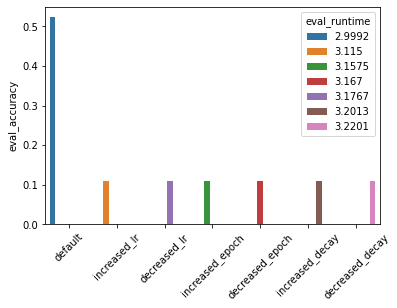

In [19]:


df = DataFrame()
df = append_dict_df(df, default_accuracy, 'default')
df = append_dict_df(df, q1_increased_lr_accuracy, 'increased_lr')
df = append_dict_df(df, q1_decreased_lr_accuracy, 'decreased_lr')
df = append_dict_df(df, q1_increased_epoch_accuracy, 'increased_epoch')
df = append_dict_df(df, q1_decreased_epoch_accuracy, 'decreased_epoch')
df = append_dict_df(df, q1_increased_decay_accuracy, 'increased_decay')
df = append_dict_df(df, q1_decreased_decay_accuracy, 'decreased_decay')

print(df.head())

ax = sns.barplot(x=df.index, y='eval_accuracy', data=df, hue='eval_runtime')
plt.xticks(rotation=45)
plt.show()

## Answer 1: I would go with the default hyperparameters as it takes the
## optimal time to train and changing the default
## parameter doesn't have any significant improvement on eval accuracy.

In [20]:
## Question 2 - trying two other models (bert-base-uncased and xlm-roberta-base)

## bert-base-uncased
model_name = 'bert-base-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
model = AutoModelForSequenceClassification.from_config(config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)



In [21]:
df = DataFrame()
increased_lr_trainer = get_trainer(_args=get_args(lr=4e-5), _model=model, _dataset=encoded_dataset)
increased_lr_trainer.train()
increased_lr_accuracy = increased_lr_trainer.evaluate()

decreased_lr_trainer = get_trainer(get_args(lr=1e-5), _model=model, _dataset=encoded_dataset)
decreased_lr_trainer.train()
decreased_lr_accuracy = decreased_lr_trainer.evaluate()

## Changing epochs
increased_epoch_trainer = get_trainer(get_args(num_epochs=3), _model=model, _dataset=encoded_dataset)
increased_epoch_trainer.train()
increased_epoch_accuracy = increased_epoch_trainer.evaluate()

decreased_epoch_trainer = get_trainer(get_args(num_epochs=1), _model=model, _dataset=encoded_dataset)
decreased_epoch_trainer.train()
decreased_epoch_accuracy = decreased_epoch_trainer.evaluate()

## decay
increased_decay_trainer = get_trainer(get_args(decay=0.04), _model=model, _dataset=encoded_dataset)
increased_decay_trainer.train()
increased_decay_accuracy = increased_decay_trainer.evaluate()

decreased_decay_trainer = get_trainer(get_args(decay=0.005), _model=model, _dataset=encoded_dataset)
decreased_decay_trainer.train()
decreased_decay_accuracy = decreased_decay_trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.623500,1.861540,0.494587,6.815500,433.719000
2,1.933800,1.665342,0.542963,6.865300,430.572000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,1.556700,1.616076,0.550068,6.836600,432.378000
2,1.348900,1.594054,0.557172,6.838600,432.255000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,1.364000,1.623467,0.558863,6.837700,432.312000
2,1.175700,1.641305,0.565291,6.877100,429.830000
3,1.114000,1.595260,0.578823,6.892800,428.851000


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.842700,1.697159,0.578146,6.874900,429.970000


Epoch,Training Loss,Validation Loss


RuntimeError: ignored

In [ ]:


df = DataFrame()
df = append_dict_df(df, default_accuracy, 'default')
df = append_dict_df(df, increased_lr_accuracy, 'increased_lr')
df = append_dict_df(df, decreased_lr_accuracy, 'decreased_lr')
df = append_dict_df(df, increased_epoch_accuracy, 'increased_epoch')
df = append_dict_df(df, decreased_epoch_accuracy, 'decreased_epoch')
df = append_dict_df(df, increased_decay_accuracy, 'increased_decay')
df = append_dict_df(df, decreased_decay_accuracy, 'decreased_decay')

print(df.head())

ax = sns.barplot(x=df.index, y='eval_accuracy', data=df, hue='eval_runtime')
plt.xticks(rotation=45)
plt.show()

In [ ]:
## xlm-roberta-base
model_name = 'xlm-roberta-base'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
model = AutoModelForSequenceClassification.from_config(config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [ ]:
df = DataFrame()
increased_lr_trainer = get_trainer(_args=get_args(lr=4e-5), _model=model, _dataset=encoded_dataset)
increased_lr_trainer.train()
increased_lr_accuracy = increased_lr_trainer.evaluate()

decreased_lr_trainer = get_trainer(get_args(lr=1e-5), _model=model, _dataset=encoded_dataset)
decreased_lr_trainer.train()
decreased_lr_accuracy = decreased_lr_trainer.evaluate()

## Changing epochs
increased_epoch_trainer = get_trainer(get_args(num_epochs=3), _model=model, _dataset=encoded_dataset)
increased_epoch_trainer.train()
increased_epoch_accuracy = increased_epoch_trainer.evaluate()

decreased_epoch_trainer = get_trainer(get_args(num_epochs=1), _model=model, _dataset=encoded_dataset)
decreased_epoch_trainer.train()
decreased_epoch_accuracy = decreased_epoch_trainer.evaluate()

## decay
increased_decay_trainer = get_trainer(get_args(decay=0.04), _model=model, _dataset=encoded_dataset)
increased_decay_trainer.train()
increased_decay_accuracy = increased_decay_trainer.evaluate()

decreased_decay_trainer = get_trainer(get_args(decay=0.005), _model=model, _dataset=encoded_dataset)
decreased_decay_trainer.train()
decreased_decay_accuracy = decreased_decay_trainer.evaluate()

In [20]:
## Question 3
def normalize_labels(example):
    example['labels'] = 0 if labels[example['labels'][0]]=="positive" else 1
    return example

labels = ["positive", "positive", "negative", "negative", "positive", "positive", 
          "negative", "neutral", "positive", "negative", "negative",
          "negative", "negative", "positive", "negative", "positive", "negative",
          "positive", "positive", "negative", "positive", "positive", "neutral",
          "positive", "negative", "negative", "positive", "neutral"]
#index_to_labels = {index: label for index, label in enumerate(labels)}

norm_labels = ["positive","negative"]
norm_index_to_labels = {index: label for index, label in enumerate(norm_labels)}

pos_neg_dataset = restricted_dataset.filter(lambda x: (labels[x["labels"][0]] == "positive" or labels[x["labels"][0]] == "negative"))
pos_neg_dataset = pos_neg_dataset.map(normalize_labels)
show_random_elements(pos_neg_dataset['train'])

,id,labels,text
0,edaeifc,0,"I'd love me some JVG, but not that [NAME] freak [NAME]..."
1,efc3ext,0,"""I guess if you want children beaten, you have to do it yourself."" Thank you [NAME]."
2,eelumn1,0,Honestly rams are my second NFC team. I wanted you to win it all since the beginning of the playoffs and I love the team even more now
3,eesbywx,0,Omg I love it
4,ef5fgdr,1,Quite the blasé article.
5,eddpddw,0,"ah, if only i could hug a beautiful and understanding woman and cry all my depression around her neck."
6,ed84vje,0,"My two favorite channels are Inner Integration and From Surviving to Thriving. Both have many videos, and they really get it."
7,edxhnln,0,Yeaaahhh... *blushes*
8,edn5edr,0,Same! Makes me want to hug them and feed them milk.
9,eecd1qs,1,I wish I could forget. Stop reminding me :(


In [21]:

model_name = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
pos_neg_model = AutoModelForSequenceClassification.from_config(config=config)
pos_neg_tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

encoded_dataset = pos_neg_dataset.map(preprocess_function, batched=True)
#encoded_dataset = encoded_dataset.map(norm_index_to_labels)

df = DataFrame()
pos_neg_trainer = get_trainer(_args=get_args(num_epochs=1), _model=pos_neg_model, _dataset=encoded_dataset)
pos_neg_trainer.train()
pos_neg_accuracy = pos_neg_trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.581900,0.428140,0.789919,2.816700,964.954000


In [22]:
prepared_input = pos_neg_tokenizer.prepare_seq2seq_batch(["What is this stupidity"], return_tensors='pt')
pos_neg_model = pos_neg_model.to('cpu')
pos_neg_model.eval()
model_output = pos_neg_model(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
norm_index_to_labels[prediction]


'negative'

In [24]:
# Question 4
pos_neg_model.save_pretrained("taharushain/postive_negative_emotions")
pos_neg_tokenizer.save_pretrained("taharushain/postive_negative_emotions")
pos_neg_trainer.save_model("taharushain/postive_negative_emotions")

In [25]:
ll taharushain/postive_negative_emotions/


total 261908
-rw-r--r-- 1 root      1676 Mar 14 03:38 config.json
-rw-r--r-- 1 root 267940055 Mar 14 03:38 pytorch_model.bin
-rw-r--r-- 1 root       112 Mar 14 03:38 special_tokens_map.json
-rw-r--r-- 1 root       258 Mar 14 03:38 tokenizer_config.json
-rw-r--r-- 1 root      2159 Mar 14 03:38 training_args.bin
-rw-r--r-- 1 root    231508 Mar 14 03:38 vocab.txt


In [26]:
!zip -r taharushain/postive_negative_emotions.zip taharushain/postive_negative_emotions


  adding: taharushain/postive_negative_emotions/ (stored 0%)
  adding: taharushain/postive_negative_emotions/config.json (deflated 64%)
  adding: taharushain/postive_negative_emotions/special_tokens_map.json (deflated 40%)
  adding: taharushain/postive_negative_emotions/vocab.txt (deflated 53%)
  adding: taharushain/postive_negative_emotions/pytorch_model.bin (deflated 7%)
  adding: taharushain/postive_negative_emotions/training_args.bin (deflated 45%)
  adding: taharushain/postive_negative_emotions/tokenizer_config.json (deflated 36%)


In [27]:
from google.colab import files
files.download("taharushain/postive_negative_emotions.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
model.save_pretrained("taharushain/default")
tokenizer.save_pretrained("taharushain/default")
trainer.save_model("taharushain/default")

In [29]:
ll taharushain/default/

total 261908
-rw-r--r-- 1 root      1677 Mar 14 03:48 config.json
-rw-r--r-- 1 root 267940055 Mar 14 03:48 pytorch_model.bin
-rw-r--r-- 1 root       112 Mar 14 03:48 special_tokens_map.json
-rw-r--r-- 1 root       258 Mar 14 03:48 tokenizer_config.json
-rw-r--r-- 1 root      2159 Mar 14 03:48 training_args.bin
-rw-r--r-- 1 root    231508 Mar 14 03:48 vocab.txt


In [30]:
!zip -r taharushain/default.zip taharushain/default


  adding: taharushain/default/ (stored 0%)
  adding: taharushain/default/config.json (deflated 64%)
  adding: taharushain/default/special_tokens_map.json (deflated 40%)
  adding: taharushain/default/vocab.txt (deflated 53%)
  adding: taharushain/default/pytorch_model.bin (deflated 7%)
  adding: taharushain/default/training_args.bin (deflated 45%)
  adding: taharushain/default/tokenizer_config.json (deflated 36%)


In [31]:
from google.colab import files
files.download("taharushain/default.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Qs 1. Can you report how accuracy changes with varying the hypyerparameters defined above? How does accuracy change with increasing number of epochs? Learning rate? Mention your final choice of parameters and graph how they impact accuracy. 

Qs 2. Try any 2 other models for sequence classification supported by Huggingface and repeat Qs 1 for these. You can find a full list of these [here](https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification). (For those of you working with text for your project, you may also find several other useful models for Seq2Seq modeling, question answering, etc.)

Qs 3. Wrangle / change the data so that you can instead build a "positive" emotion vs "negative" emotions classifier, by combining labels. For any emotions that you feel are too neutral, you may drop them from evaluation. Can you now report the accuracy of a classifer on this data? You may use one of the model architectures from (1) or (2)

Qs 4. Export models from qs 1 and 3, and build a FastAPI around it, as discussed in class, which returns the most likely emotion found. (You may need to look up Huggingface documentation on how to save and load models). In particular, you should support two API endpoints - "detect_emotion_binary" and "detect_emotion_full" which supports each model.

Qs 5. Finally, can you dockerize this? You do NOT need to deploy this to the cloud.

Submission instructions: Zip your compiled .ipynb notebook, your fast_api code and your dockerfile, and submit to LMS as one file. You should confirm that your .ipynb can be imported to colab and run in sequence. All your results for Qs 1-3 should be reported in the notebook itself.